In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score , confusion_matrix
from torchvision.models import VGG16_Weights
import seaborn as sns

# Upload & Read Data

In [3]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 150
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
device

device(type='cuda', index=0)

In [5]:
MSS_train = '/content/drive/MyDrive/MSS_train'
MSI_train = '/content/drive/MyDrive/MSI_train'

In [6]:
print(f'Number of Microsatellite Stability images - train folder: {len(os.listdir(MSS_train))}')
print(f'Number of Microsatellite Instability - train folder: {len(os.listdir(MSI_train))}')

Number of Microsatellite Stability images - train folder: 596
Number of Microsatellite Instability - train folder: 603


In [7]:
MSS_test = '/content/drive/MyDrive/MSS_test'
MSI_test = '/content/drive/MyDrive/MSI_test'

In [8]:
print(f'Number of Microsatellite Stability images - test folder: {len(os.listdir(MSS_test))}')
print(f'Number of Microsatellite Instability images - test folder: {len(os.listdir(MSI_test))}')

Number of Microsatellite Stability images - test folder: 403
Number of Microsatellite Instability images - test folder: 463


In [9]:
MSS_val = '/content/drive/MyDrive/MSS_val'
MSI_val = '/content/drive/MyDrive/MSI_val'

In [10]:
print(f'Number of Microsatellite Stability images - val folder: {len(os.listdir(MSS_val))}')
print(f'Number of Microsatellite Instability images - val folder: {len(os.listdir(MSI_val))}')

Number of Microsatellite Stability images - val folder: 210
Number of Microsatellite Instability images - val folder: 205


**Defining Data augmentation and normalization for training using transforms**

> Resize image to (224, 244)

> Normalize the image demistion to (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [11]:
data_transforms = transforms.Compose([
    #resizes the input image to the specified size of (224, 224) pixels.
    transforms.Resize((224, 224)),
    #Convert Image to Pytorch tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

**Load the datasets with ImageFolder**

In [12]:
# ImageFolder: PyTorch utility for loading image data
train_data = ImageFolder(root='/content/drive/MyDrive/train_GC', transform=data_transforms)
test_data = ImageFolder(root='/content/drive/MyDrive/test_GC', transform=data_transforms)
val_data = ImageFolder(root='/content/drive/MyDrive/val_GC', transform=data_transforms)

# **Create a classifier using pre-trained model from pytorch - VGG16**


# **On Val Test**

First combination lr= 0.003  wd=0.001 momentom=0.5 batch size= 64

In [ ]:
# Create data loaders with batch size 64
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Initialize the VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Modify the classifier to fit binary classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer with weight decay and momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=0.001, momentum=0.5)

# Training the model
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val phase
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s] 


Epoch 0/9, Loss: 0.7231, Train Accuracy: 0.5221
Epoch 1/9, Loss: 0.6592, Train Accuracy: 0.5947
Epoch 2/9, Loss: 0.6341, Train Accuracy: 0.6405
Epoch 3/9, Loss: 0.5870, Train Accuracy: 0.6706
Epoch 4/9, Loss: 0.5702, Train Accuracy: 0.7039
Epoch 5/9, Loss: 0.5209, Train Accuracy: 0.7448
Epoch 6/9, Loss: 0.5192, Train Accuracy: 0.7490
Epoch 7/9, Loss: 0.4339, Train Accuracy: 0.8007
Epoch 8/9, Loss: 0.4217, Train Accuracy: 0.7998
Epoch 9/9, Loss: 0.3514, Train Accuracy: 0.8524
Training Accuracy: 0.8524


In [ ]:
# Calculate and print overall accuracy using sklearn's accuracy_score
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.7133


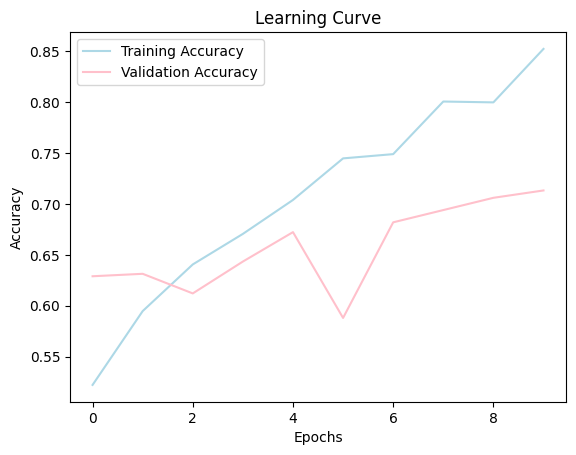

Training Accuracy: 0.8524
Validation Accuracy: 0.7133


In [ ]:
# Plot learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Second combination lr= 0.001 wd=0.005 momentom=0.7 batch size= 32

In [ ]:
# Create data loaders with batch size 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Initialize the VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Modify the classifier to fit binary classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer with weight decay and momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.005, momentum=0.7)


# Training the model
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val phase
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 0/9, Loss: 0.7210, Train Accuracy: 0.5405
Epoch 1/9, Loss: 0.6549, Train Accuracy: 0.6197
Epoch 2/9, Loss: 0.6211, Train Accuracy: 0.6631
Epoch 3/9, Loss: 0.5895, Train Accuracy: 0.6872
Epoch 4/9, Loss: 0.5786, Train Accuracy: 0.6897
Epoch 5/9, Loss: 0.5183, Train Accuracy: 0.7456
Epoch 6/9, Loss: 0.4810, Train Accuracy: 0.7673
Epoch 7/9, Loss: 0.4318, Train Accuracy: 0.7932
Epoch 8/9, Loss: 0.3682, Train Accuracy: 0.8324
Epoch 9/9, Loss: 0.3667, Train Accuracy: 0.8365
Training Accuracy: 0.8365


In [ ]:
# Calculate and print overall accuracy using sklearn's accuracy_score
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.7205


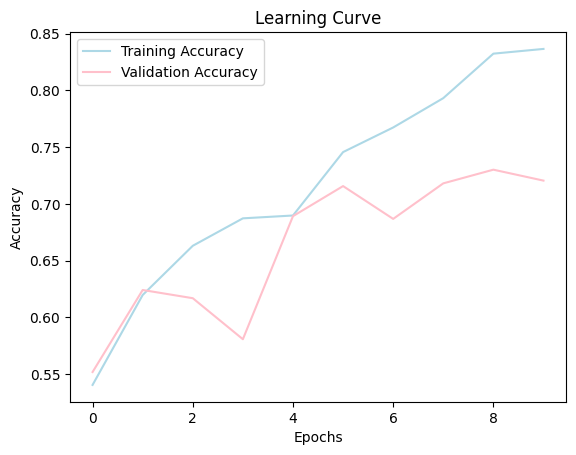

Training Accuracy: 0.8365
Validation Accuracy: 0.7205


In [ ]:
# Plot learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Third combination lr= 0.001 wd=0.01 momentom=0.7 batch size= 64

In [ ]:
# Create data loaders with batch size 64
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Initialize the VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Modify the classifier to fit binary classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer with weight decay and momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01, momentum=0.7)


# Training the model
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val phase
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


Epoch 0/9, Loss: 0.7149, Train Accuracy: 0.5304
Epoch 1/9, Loss: 0.6814, Train Accuracy: 0.5688
Epoch 2/9, Loss: 0.6458, Train Accuracy: 0.6272
Epoch 3/9, Loss: 0.6472, Train Accuracy: 0.6155
Epoch 4/9, Loss: 0.6251, Train Accuracy: 0.6489
Epoch 5/9, Loss: 0.5935, Train Accuracy: 0.6772
Epoch 6/9, Loss: 0.5732, Train Accuracy: 0.7139
Epoch 7/9, Loss: 0.5557, Train Accuracy: 0.7264
Epoch 8/9, Loss: 0.5251, Train Accuracy: 0.7448
Epoch 9/9, Loss: 0.5044, Train Accuracy: 0.7531
Training Accuracy: 0.7531


In [ ]:
# Calculate and print overall accuracy using sklearn's accuracy_score
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6843


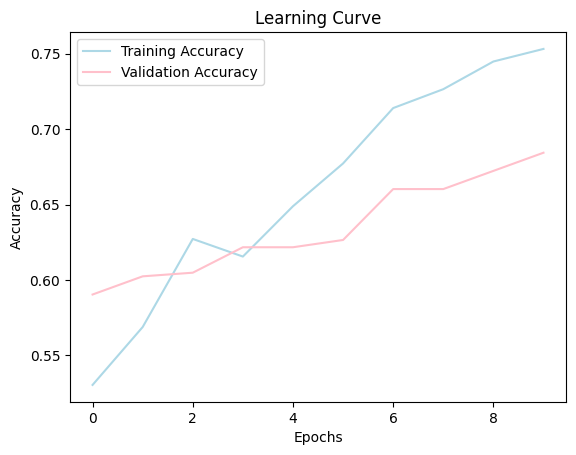

Training Accuracy: 0.7531
Validation Accuracy: 0.6843


In [ ]:
# Plot learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

Fourth combination lr= 0.003 wd=0.001 momentom=0.5 batch size= 128

In [ ]:
# Create data loaders with batch size 128
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

# Initialize the VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Modify the classifier to fit binary classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer with weight decay and momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=0.001, momentum=0.5)


# Training the model
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # val phase
    model.eval()
    correct_val= 0
    total_val = len(val_data)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct_val/ total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.89 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.73 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 3.10 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/

Epoch 0/9, Loss: 0.7270, Train Accuracy: 0.5088
Epoch 1/9, Loss: 0.6841, Train Accuracy: 0.5605
Epoch 2/9, Loss: 0.6466, Train Accuracy: 0.6138
Epoch 3/9, Loss: 0.6308, Train Accuracy: 0.6580
Epoch 4/9, Loss: 0.6218, Train Accuracy: 0.6522
Epoch 5/9, Loss: 0.5929, Train Accuracy: 0.6856
Epoch 6/9, Loss: 0.5799, Train Accuracy: 0.6914
Epoch 7/9, Loss: 0.5400, Train Accuracy: 0.7223
Epoch 8/9, Loss: 0.5231, Train Accuracy: 0.7306
Epoch 9/9, Loss: 0.5271, Train Accuracy: 0.7298
Training Accuracy: 0.7298


In [ ]:
# Calculate and print overall accuracy using sklearn's accuracy_score
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on val Set: {overall_accuracy:.4f}')

Overall Accuracy on val Set: 0.6386


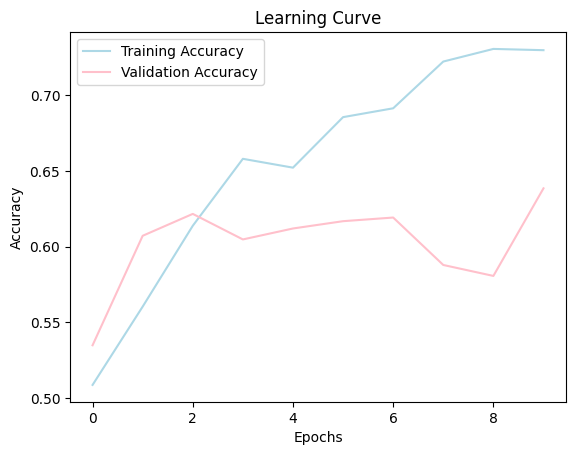

Training Accuracy: 0.7298
Validation Accuracy: 0.6386


In [ ]:
# Plot learning curve
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy',color='lightblue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy',color='pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

print(f'Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}')

# **On Test Set**

In [13]:
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [14]:
#Create data loaders with batch size 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Initialize the VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Modify the classifier to fit binary classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Display model parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params}")

# Define loss function and optimizer with weight decay and momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),  lr=0.001, weight_decay=0.005, momentum=0.7)

# Training the model
num_epochs = 10
train_accuracies = []
test_accuracies = []

# Start training time measurement
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Testing phase
    model.eval()
    correct_test= 0
    total_test = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct_test/ total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

# Calculate and print training time
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/your_trained_model.pth')

# Print final training accuracy
print(f'Training Accuracy: {train_accuracies[-1]:.4f}')

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f'Confusion Matrix:\n{conf_matrix}')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 93.6MB/s]


Number of parameters in the model: 134268738
Epoch 0/9, Loss: 0.7085, Train Accuracy: 0.5455
Epoch 1/9, Loss: 0.6568, Train Accuracy: 0.6038
Epoch 2/9, Loss: 0.6368, Train Accuracy: 0.6289
Epoch 3/9, Loss: 0.5869, Train Accuracy: 0.6906
Epoch 4/9, Loss: 0.5549, Train Accuracy: 0.7239
Epoch 5/9, Loss: 0.5205, Train Accuracy: 0.7389
Epoch 6/9, Loss: 0.4639, Train Accuracy: 0.7840
Epoch 7/9, Loss: 0.4268, Train Accuracy: 0.7915
Epoch 8/9, Loss: 0.3607, Train Accuracy: 0.8332
Epoch 9/9, Loss: 0.3125, Train Accuracy: 0.8874
Total training time: 853.29 seconds
Training Accuracy: 0.8874
Confusion Matrix:
[[304 159]
 [ 99 304]]


In [15]:
# Calculate and print overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy on Test Set: {overall_accuracy:.4f}')

# Calculate and print classification report
class_report = classification_report(all_labels, all_preds)
print(f'Classification Report:\n{class_report}')

Overall Accuracy on Test Set: 0.7021
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       463
           1       0.66      0.75      0.70       403

    accuracy                           0.70       866
   macro avg       0.71      0.71      0.70       866
weighted avg       0.71      0.70      0.70       866



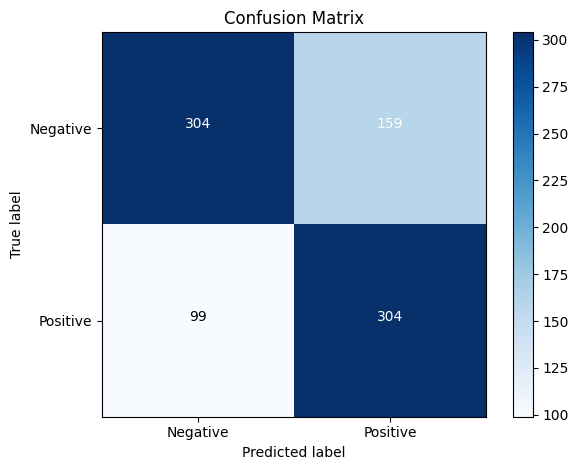

In [16]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


# **Interface**

Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQVCIQDISFQG-TCGA-D5-6530-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQLWTDNCDGIM-TCGA-CM-6171-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQMWRCKLLDEK-TCGA-NH-A5IV-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQSNLFLWKRDR-TCGA-CM-4743-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-AQTISQRRTKGR-TCGA-G4-6304-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-AQIGPHSNLCHK-TCGA-QG-A5Z2-01Z-00-DX2.jpg, Predicted Class: MSI
Predicted class: MSS
Image: /content/drive/MyDrive/load images/blk-APWSWWVKRGMA-TCGA-AA-3875-01Z-00-DX1.jpg, Predicted Class: MSS
Predicted class: MSI
Image: /content/drive/MyDrive/load images/blk-APVARSWHLQNK-TCGA-CM-58

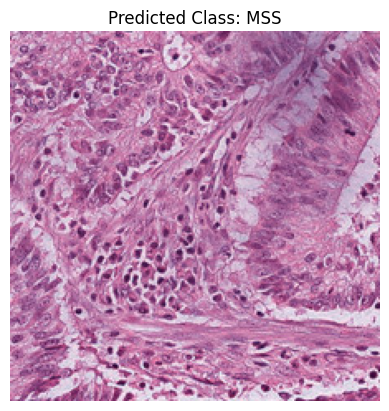

Predicted class: MSS


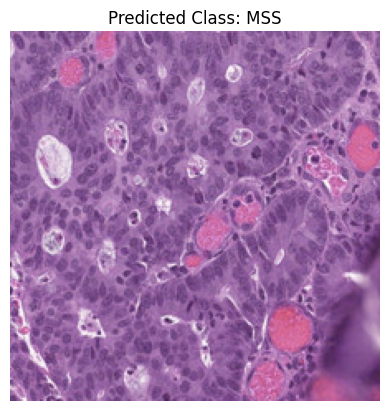

Predicted class: MSS


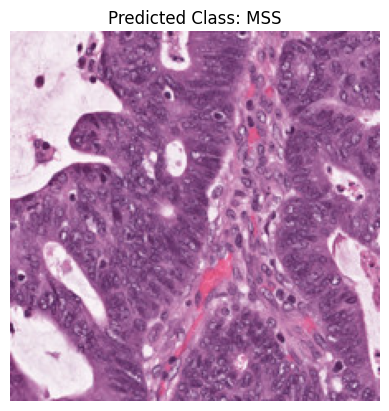

Predicted class: MSS


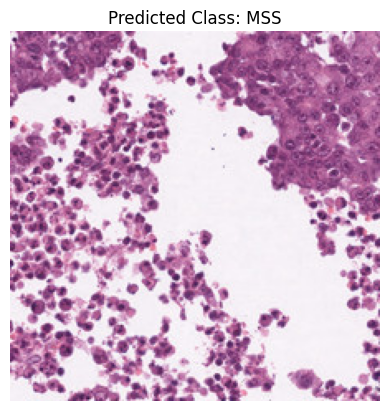

Predicted class: MSS


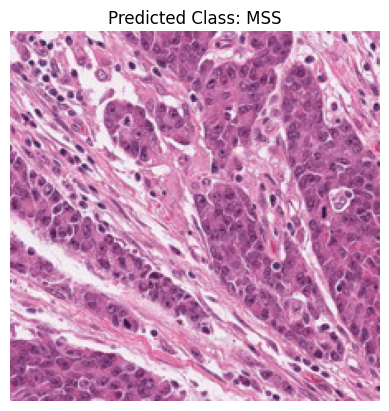

Predicted class: MSI


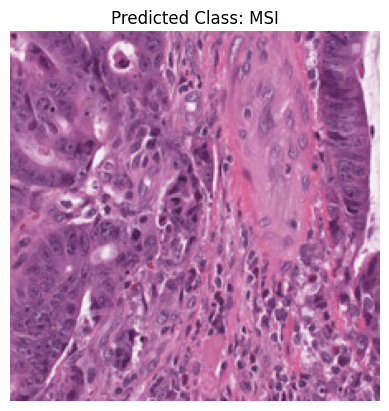

Predicted class: MSS


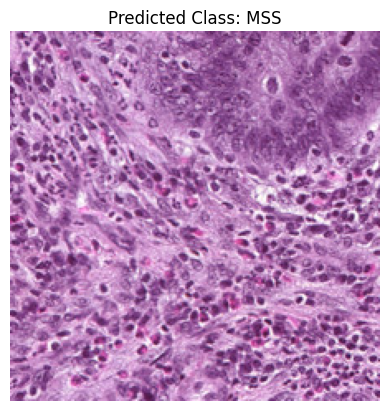

Predicted class: MSI


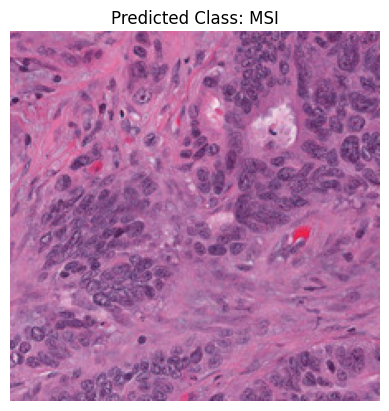

Predicted class: MSI


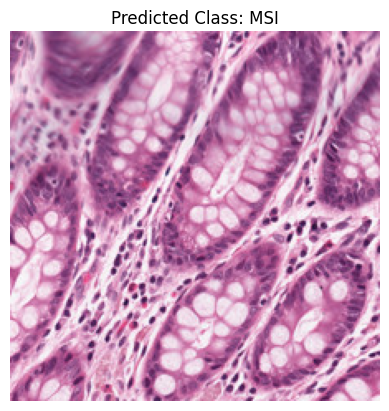

Predicted class: MSI


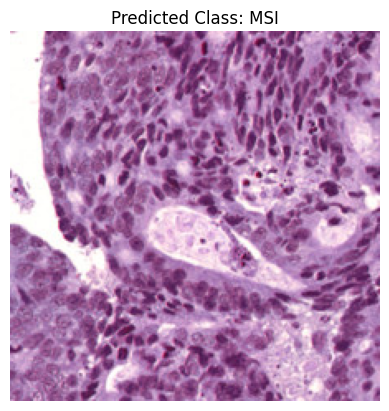

Predicted class: MSI


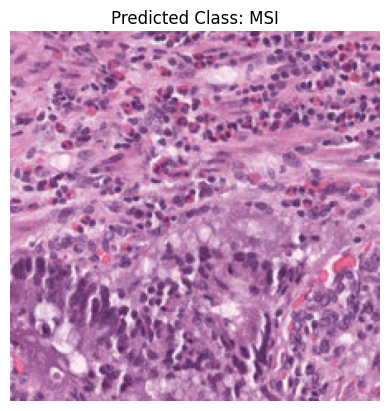

Predicted class: MSI


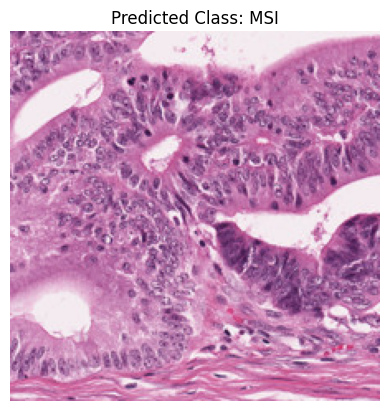

In [17]:
# Define transform for input image preprocessing
input_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Modify the classifier to fit binary classification
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

model.load_state_dict(torch.load('/content/drive/MyDrive/your_trained_model.pth'))
model.eval()

# Define classes
classes = ['MSS', 'MSI']

def predict_image(file_path):
    # Print file path
    #print("Processing image:", file_path)

    # Open and preprocess the image
    img = Image.open(file_path)
    img = input_transform(img)
    img = img.unsqueeze(0)  # Add batch dimension

    # Perform prediction
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        predicted_class = classes[predicted.item()]

    # Print predicted class
    print("Predicted class:", predicted_class)

    # Return the predicted class
    return predicted_class

# Directory containing images to classify
image_dir = '/content/drive/MyDrive/load images'

# List all image files in the directory
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Loop through each image and make a prediction
for image_file in image_files:
    prediction = predict_image(image_file)
    print(f"Image: {image_file}, Predicted Class: {prediction}")


import matplotlib.pyplot as plt

# Function to display image and prediction
def show_prediction(file_path, predicted_class):
    # Open and display image
    img = Image.open(file_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Loop through each image and make a prediction
for image_file in image_files:
    prediction = predict_image(image_file)
    show_prediction(image_file, prediction)